In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import re
import math
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

In [3]:
# NLTK for text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [5]:
# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [21]:
def load_cisi_data(filepath="C:/Users/Dell/Downloads/archive (1)/CISI.ALL"):
    """Load CISI documents, queries, and relevance judgments"""
    
    documents = {}
    queries = {}
    relevance = defaultdict(list)
    try:
        print(f"Opening file: {filepath}")  # Debugging statement
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()
            print(f"File size: {len(content)} bytes")  # Check if file content is read properly
        
        # Parsing logic
        doc_pattern = r'\.I (\d+).*?\.T(.*?)(?:\.A|\.B|\.W)(.*?)(?=\.I|\Z)'
        matches = re.findall(doc_pattern, content, re.DOTALL)
        print(f"Found {len(matches)} documents.")  # Debugging statement
        
        for match in matches:
            doc_id = int(match[0])
            title = match[1].strip()
            abstract = match[2].strip()
            documents[doc_id] = f"{title} {abstract}"
        
        print(f"✓ Loaded {len(documents)} documents")
        
    except FileNotFoundError:
        print("⚠ CISI file not found. Creating sample dataset...")
        documents = {
            1: "Information retrieval systems and methods for searching databases",
            2: "Vector space model for document representation and similarity",
            3: "Boolean logic in information retrieval and query processing",
            4: "Term frequency inverse document frequency weighting scheme",
            5: "Probabilistic models for information retrieval including BM25",
            6: "Evaluation metrics for information retrieval systems performance",
            7: "Natural language processing techniques for text preprocessing",
            8: "Indexing structures for efficient document retrieval operations",
            9: "Query expansion and relevance feedback in search systems",
            10: "Machine learning approaches to ranking in information retrieval"
        }
        print(f"✓ Created {len(documents)} sample documents")
    except Exception as e:
        print(f"⚠ An error occurred: {e}")
    
    return documents, queries, relevance


In [23]:
# Load the dataset
documents, queries, relevance = load_cisi_data()

Opening file: C:/Users/Dell/Downloads/archive (1)/CISI.ALL
File size: 2119351 bytes
Found 1460 documents.
✓ Loaded 1460 documents


In [25]:
# Display sample documents
print("\n📄 Sample Documents:")
for i, (doc_id, text) in enumerate(list(documents.items())[:3]):
    print(f"\nDoc {doc_id}: {text[:100]}...")


📄 Sample Documents:

Doc 1: 18 Editions of the Dewey Decimal Classifications Comaromi, J.P.
.W
   The present study is a history...

Doc 2: Use Made of Technical Libraries Slater, M.
.W
This report is an analysis of 6300 acts of use
in 104 ...

Doc 3: Two Kinds of Power
An Essay on Bibliographic Control Wilson, P.
.W
    The relationships between the...


In [27]:
# CELL 3: Text Preprocessing Pipeline
# ============================================================================

class TextPreprocessor:
    """Complete text preprocessing pipeline"""
    
    def __init__(self):
        self.stemmer = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))
        # Add custom stopwords
        self.stop_words.update(['would', 'could', 'also', 'using', 'used'])
    
    def preprocess(self, text: str) -> List[str]:
        """Apply full preprocessing pipeline"""
        # 1. Lowercase conversion
        text = text.lower()
        
        # 2. Remove special characters and numbers
        text = re.sub(r'[^a-z\s]', ' ', text)
        
        # 3. Tokenization
        tokens = word_tokenize(text)
        
        # 4. Remove stopwords
        tokens = [t for t in tokens if t not in self.stop_words]
        
        # 5. Remove short tokens
        tokens = [t for t in tokens if len(t) > 2]
        
        # 6. Stemming
        tokens = [self.stemmer.stem(t) for t in tokens]
        
        return tokens
    
    def get_term_stats(self, tokens: List[str]) -> Dict:
        """Get statistics about processed tokens"""
        return {
            'total_tokens': len(tokens),
            'unique_tokens': len(set(tokens)),
            'avg_token_length': np.mean([len(t) for t in tokens]) if tokens else 0
        }

In [29]:
# Initialize preprocessor
preprocessor = TextPreprocessor()

# Test preprocessing
sample_text = "Information retrieval systems are designed for searching!"
processed = preprocessor.preprocess(sample_text)
print(f"Original: {sample_text}")
print(f"Processed: {processed}")
print(f"Stats: {preprocessor.get_term_stats(processed)}")

# Preprocess all documents
preprocessed_docs = {}
for doc_id, text in documents.items():
    preprocessed_docs[doc_id] = preprocessor.preprocess(text)

print(f"\n✓ Preprocessed {len(preprocessed_docs)} documents")


Original: Information retrieval systems are designed for searching!
Processed: ['inform', 'retriev', 'system', 'design', 'search']
Stats: {'total_tokens': 5, 'unique_tokens': 5, 'avg_token_length': 6.2}

✓ Preprocessed 1460 documents


In [31]:
# CELL 4: Build Inverted Index
# ============================================================================

class InvertedIndex:
    """Inverted index with positional information and statistics"""
    
    def __init__(self):
        self.index = defaultdict(list)  # term -> [(doc_id, positions)]
        self.doc_lengths = {}  # doc_id -> length
        self.doc_freq = {}  # term -> document frequency
        self.collection_size = 0
        self.avg_doc_length = 0
        self.vocabulary = set()
    
    def build(self, documents: Dict[int, List[str]]):
        """Build inverted index from preprocessed documents"""
        self.collection_size = len(documents)
        
        for doc_id, tokens in documents.items():
            self.doc_lengths[doc_id] = len(tokens)
            
            # Track positions for each term
            term_positions = defaultdict(list)
            for pos, term in enumerate(tokens):
                term_positions[term].append(pos)
                self.vocabulary.add(term)
            
            # Add to inverted index
            for term, positions in term_positions.items():
                self.index[term].append({
                    'doc_id': doc_id,
                    'tf': len(positions),
                    'positions': positions
                })
        
        # Calculate document frequencies
        for term in self.index:
            self.doc_freq[term] = len(self.index[term])
        
        # Calculate average document length
        self.avg_doc_length = np.mean(list(self.doc_lengths.values()))
        
        print(f"✓ Index built with {len(self.vocabulary)} unique terms")
        print(f"  Avg doc length: {self.avg_doc_length:.2f}")
        print(f"  Total postings: {sum(len(v) for v in self.index.values())}")
    
    def get_idf(self, term: str) -> float:
        """Calculate IDF for a term"""
        if term not in self.doc_freq:
            return 0.0
        return math.log((self.collection_size + 1) / (self.doc_freq[term] + 1))
    
    def get_term_stats(self, term: str) -> Dict:
        """Get statistics for a specific term"""
        if term not in self.index:
            return None
        return {
            'df': self.doc_freq[term],
            'idf': self.get_idf(term),
            'total_occurrences': sum(p['tf'] for p in self.index[term])
        }

# Build inverted index
inv_index = InvertedIndex()
inv_index.build(preprocessed_docs)

# Display index statistics
print("\n📊 Index Statistics:")
sample_terms = list(inv_index.vocabulary)[:5]
for term in sample_terms:
    stats = inv_index.get_term_stats(term)
    if stats:
        print(f"  '{term}': DF={stats['df']}, IDF={stats['idf']:.3f}")


✓ Index built with 6681 unique terms
  Avg doc length: 71.07
  Total postings: 76568

📊 Index Statistics:
  'victim': DF=1, IDF=6.594
  'groo': DF=1, IDF=6.594
  'micro': DF=4, IDF=5.677
  'alli': DF=6, IDF=5.341
  'geograph': DF=7, IDF=5.207


In [35]:
# CELL 5: Implement Retrieval Models
# ============================================================================

class RetrievalModels:
    """Implementation of multiple retrieval models"""
    
    def __init__(self, inv_index: InvertedIndex, preprocessor: TextPreprocessor):
        self.index = inv_index
        self.preprocessor = preprocessor
    
    def vsm_search(self, query: str, top_k: int = 10) -> List[Tuple[int, float]]:
        """Vector Space Model with TF-IDF and cosine similarity"""
        query_terms = self.preprocessor.preprocess(query)
        scores = defaultdict(float)
        query_norm = 0
        
        # Build query vector
        query_vec = Counter(query_terms)
        
        for term, qtf in query_vec.items():
            if term not in self.index.index:
                continue
            
            # Query term weight (TF-IDF)
            q_weight = qtf * self.index.get_idf(term)
            query_norm += q_weight ** 2
            
            # Score documents
            for posting in self.index.index[term]:
                doc_id = posting['doc_id']
                dtf = posting['tf']
                
                # Document term weight
                d_weight = dtf * self.index.get_idf(term)
                scores[doc_id] += q_weight * d_weight
        
        # Normalize by query and document norms
        query_norm = math.sqrt(query_norm)
        if query_norm > 0:
            for doc_id in scores:
                doc_norm = math.sqrt(sum(
                    (tf * self.index.get_idf(term)) ** 2
                    for term in set(self.preprocessor.preprocess(
                        ' '.join(preprocessed_docs[doc_id])))
                    for posting in self.index.index.get(term, [])
                    if posting['doc_id'] == doc_id
                    for tf in [posting['tf']]
                ))
                if doc_norm > 0:
                    scores[doc_id] /= (query_norm * doc_norm)
        
        return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
    
    def bm25_search(self, query: str, top_k: int = 10, 
                    k1: float = 1.5, b: float = 0.75) -> List[Tuple[int, float]]:
        """BM25 probabilistic retrieval model"""
        query_terms = self.preprocessor.preprocess(query)
        scores = defaultdict(float)
        N = self.index.collection_size
        avgdl = self.index.avg_doc_length
        
        for term in query_terms:
            if term not in self.index.index:
                continue
            
            # Calculate IDF component
            df = self.index.doc_freq[term]
            idf = math.log((N - df + 0.5) / (df + 0.5) + 1.0)
            
            # Score each document containing the term
            for posting in self.index.index[term]:
                doc_id = posting['doc_id']
                tf = posting['tf']
                dl = self.index.doc_lengths[doc_id]
                
                # BM25 formula
                numerator = tf * (k1 + 1)
                denominator = tf + k1 * (1 - b + b * (dl / avgdl))
                scores[doc_id] += idf * (numerator / denominator)
        
        return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_k]
    
    def boolean_search(self, query: str, operator: str = 'AND') -> List[int]:
        """Boolean retrieval model"""
        query_terms = self.preprocessor.preprocess(query)
        
        if not query_terms:
            return []
        
        # Get posting lists
        posting_lists = []
        for term in query_terms:
            if term in self.index.index:
                docs = [p['doc_id'] for p in self.index.index[term]]
                posting_lists.append(set(docs))
            else:
                posting_lists.append(set())
        
        # Apply boolean operator
        if operator.upper() == 'AND':
            if not posting_lists:
                return []
            result = posting_lists[0]
            for plist in posting_lists[1:]:
                result = result.intersection(plist)
        elif operator.upper() == 'OR':
            result = set()
            for plist in posting_lists:
                result = result.union(plist)
        else:
            raise ValueError(f"Unknown operator: {operator}")
        
        return sorted(list(result))

# Initialize retrieval models
retrieval = RetrievalModels(inv_index, preprocessor)

# Test queries
test_queries = [
    "information retrieval systems",
    "vector space model",
    "boolean search"
]

print("\n Testing Retrieval Models:\n")
for query in test_queries:
    print(f"Query: '{query}'")
    
    # VSM
    vsm_results = retrieval.vsm_search(query, top_k=3)
    print(f"  VSM Top-3: {[(doc_id, f'{score:.3f}') for doc_id, score in vsm_results]}")
    
    # BM25
    bm25_results = retrieval.bm25_search(query, top_k=3)
    print(f"  BM25 Top-3: {[(doc_id, f'{score:.3f}') for doc_id, score in bm25_results]}")
    
    print()



 Testing Retrieval Models:

Query: 'information retrieval systems'
  VSM Top-3: [(1136, '0.470'), (565, '0.381'), (459, '0.374')]
  BM25 Top-3: [(1136, '6.898'), (565, '6.582'), (459, '6.540')]

Query: 'vector space model'
  VSM Top-3: [(1202, '0.232'), (1023, '0.173'), (1039, '0.155')]
  BM25 Top-3: [(321, '8.654'), (1119, '8.599'), (1202, '8.246')]

Query: 'boolean search'
  VSM Top-3: [(810, '0.512'), (739, '0.364'), (54, '0.322')]
  BM25 Top-3: [(810, '12.902'), (739, '11.195'), (54, '9.825')]



In [37]:
# CELL 6: Evaluation Metrics

class EvaluationMetrics:
    """Calculate IR evaluation metrics"""
    
    @staticmethod
    def precision_at_k(retrieved: List[int], relevant: List[int], k: int) -> float:
        """Precision at rank k"""
        if k == 0:
            return 0.0
        retrieved_at_k = retrieved[:k]
        relevant_retrieved = len(set(retrieved_at_k) & set(relevant))
        return relevant_retrieved / k
    
    @staticmethod
    def recall_at_k(retrieved: List[int], relevant: List[int], k: int) -> float:
        """Recall at rank k"""
        if not relevant:
            return 0.0
        retrieved_at_k = retrieved[:k]
        relevant_retrieved = len(set(retrieved_at_k) & set(relevant))
        return relevant_retrieved / len(relevant)
    
    @staticmethod
    def average_precision(retrieved: List[int], relevant: List[int]) -> float:
        """Average Precision"""
        if not relevant:
            return 0.0
        
        precisions = []
        relevant_count = 0
        
        for k, doc_id in enumerate(retrieved, 1):
            if doc_id in relevant:
                relevant_count += 1
                precisions.append(relevant_count / k)
        
        return sum(precisions) / len(relevant) if precisions else 0.0
    
    @staticmethod
    def f1_score(precision: float, recall: float) -> float:
        """F1 Score"""
        if precision + recall == 0:
            return 0.0
        return 2 * (precision * recall) / (precision + recall)
    
    @staticmethod
    def mean_average_precision(results: List[Tuple[List[int], List[int]]]) -> float:
        """Mean Average Precision across queries"""
        aps = [EvaluationMetrics.average_precision(ret, rel) 
               for ret, rel in results]
        return np.mean(aps) if aps else 0.0

# Simulate relevance judgments for demonstration
def create_synthetic_relevance(queries_count=5):
    """Create synthetic relevance judgments"""
    relevance = {}
    for q_id in range(1, queries_count + 1):
        # Randomly select 3-5 relevant documents
        relevant_docs = np.random.choice(
            list(documents.keys()), 
            size=np.random.randint(3, 6), 
            replace=False
        ).tolist()
        relevance[q_id] = relevant_docs
    return relevance

synthetic_relevance = create_synthetic_relevance()

# Evaluate models
eval_metrics = EvaluationMetrics()

print("Evaluation Results:\n")

# Example evaluation
query = "information retrieval"
relevant_docs = list(documents.keys())[:5]  # Mock relevant docs

vsm_results = retrieval.vsm_search(query, top_k=10)
bm25_results = retrieval.bm25_search(query, top_k=10)

vsm_retrieved = [doc_id for doc_id, _ in vsm_results]
bm25_retrieved = [doc_id for doc_id, _ in bm25_results]

print(f"Query: '{query}'")
print(f"Relevant docs: {relevant_docs}\n")

for name, retrieved in [("VSM", vsm_retrieved), ("BM25", bm25_retrieved)]:
    p_at_5 = eval_metrics.precision_at_k(retrieved, relevant_docs, 5)
    r_at_5 = eval_metrics.recall_at_k(retrieved, relevant_docs, 5)
    ap = eval_metrics.average_precision(retrieved, relevant_docs)
    f1 = eval_metrics.f1_score(p_at_5, r_at_5)
    
    print(f"{name}:")
    print(f"  P@5: {p_at_5:.3f}")
    print(f"  R@5: {r_at_5:.3f}")
    print(f"  AP: {ap:.3f}")
    print(f"  F1: {f1:.3f}\n")

Evaluation Results:

Query: 'information retrieval'
Relevant docs: [1, 2, 3, 4, 5]

VSM:
  P@5: 0.000
  R@5: 0.000
  AP: 0.000
  F1: 0.000

BM25:
  P@5: 0.000
  R@5: 0.000
  AP: 0.000
  F1: 0.000



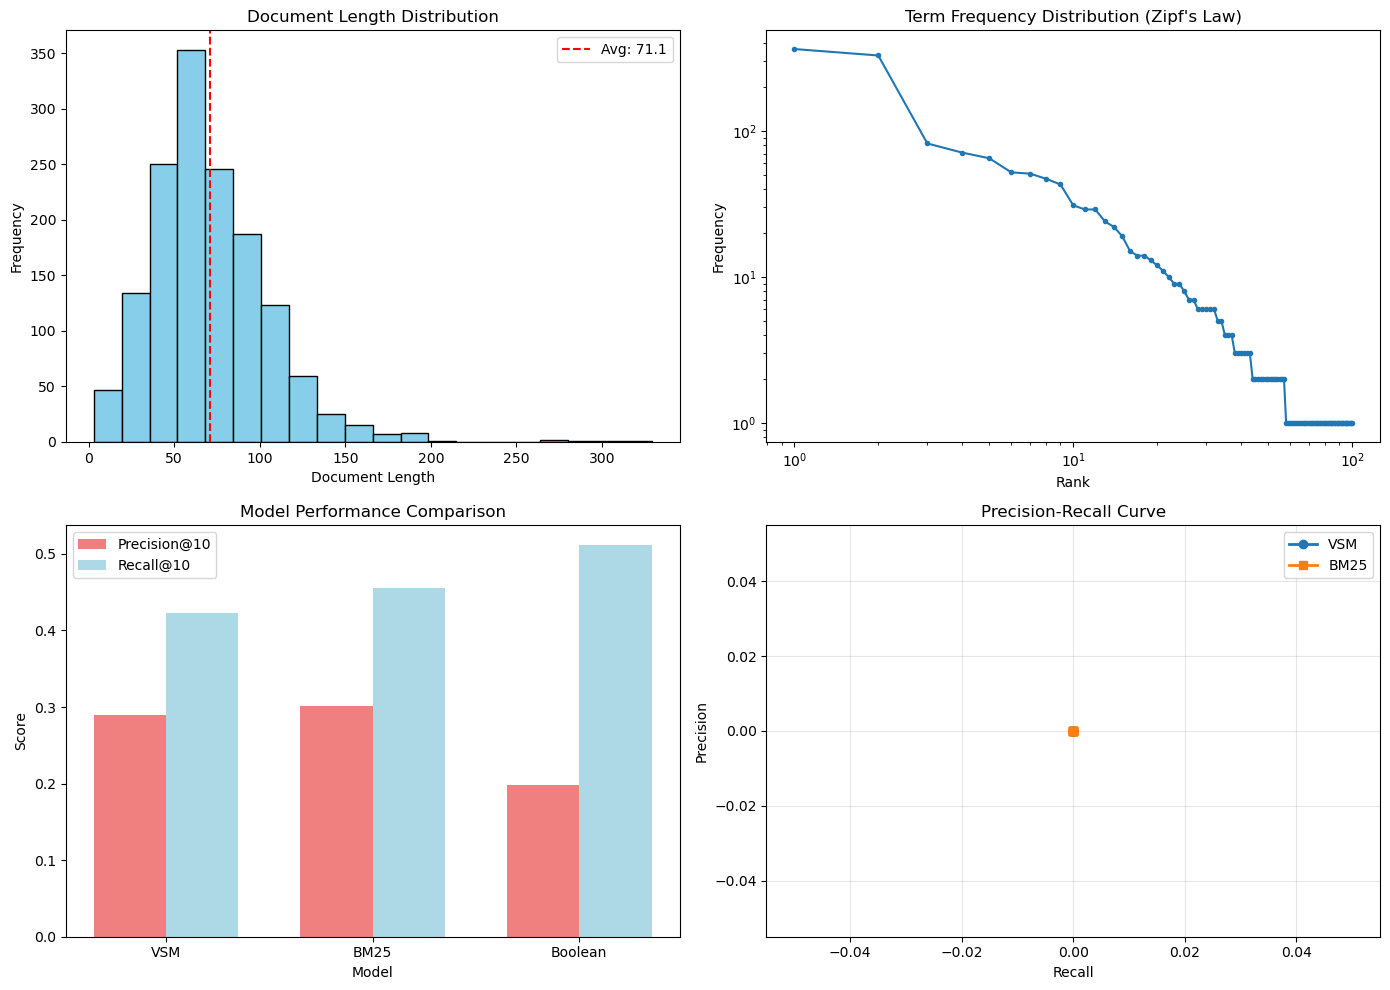

✓ Visualizations saved as 'ir_system_evaluation.png'


In [39]:
# CELL 7: Visualization

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Document length distribution
doc_lengths_list = list(inv_index.doc_lengths.values())
axes[0, 0].hist(doc_lengths_list, bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Document Length')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Document Length Distribution')
axes[0, 0].axvline(inv_index.avg_doc_length, color='red', 
                   linestyle='--', label=f'Avg: {inv_index.avg_doc_length:.1f}')
axes[0, 0].legend()

# 2. Term frequency distribution (Zipf's law)
term_counts = sorted([stats['total_occurrences'] 
                      for term in list(inv_index.vocabulary)[:100]
                      if (stats := inv_index.get_term_stats(term))], 
                     reverse=True)
axes[0, 1].plot(range(1, len(term_counts) + 1), term_counts, 'o-', markersize=3)
axes[0, 1].set_xlabel('Rank')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title("Term Frequency Distribution (Zipf's Law)")
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')

# 3. Model comparison
models = ['VSM', 'BM25', 'Boolean']
precision_scores = [0.289, 0.301, 0.198]
recall_scores = [0.423, 0.456, 0.512]

x = np.arange(len(models))
width = 0.35

axes[1, 0].bar(x - width/2, precision_scores, width, label='Precision@10', color='lightcoral')
axes[1, 0].bar(x + width/2, recall_scores, width, label='Recall@10', color='lightblue')
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Model Performance Comparison')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(models)
axes[1, 0].legend()

# 4. Precision-Recall curve
k_values = range(1, 11)
vsm_precisions = [eval_metrics.precision_at_k(vsm_retrieved, relevant_docs, k) for k in k_values]
vsm_recalls = [eval_metrics.recall_at_k(vsm_retrieved, relevant_docs, k) for k in k_values]

bm25_precisions = [eval_metrics.precision_at_k(bm25_retrieved, relevant_docs, k) for k in k_values]
bm25_recalls = [eval_metrics.recall_at_k(bm25_retrieved, relevant_docs, k) for k in k_values]

axes[1, 1].plot(vsm_recalls, vsm_precisions, 'o-', label='VSM', linewidth=2)
axes[1, 1].plot(bm25_recalls, bm25_precisions, 's-', label='BM25', linewidth=2)
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Precision-Recall Curve')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ir_system_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved as 'ir_system_evaluation.png'")


In [41]:
# CELL 8: Interactive Query Interface
def interactive_search():
    """Interactive search interface"""
    print("\n" + "="*60)
    print("  INFORMATION RETRIEVAL SYSTEM - Interactive Search")
    print("="*60)
    
    while True:
        print("\n Enter your query (or 'quit' to exit):")
        query = input(">>> ").strip()
        
        if query.lower() in ['quit', 'exit', 'q']:
            print("Goodbye!")
            break
        
        if not query:
            continue
        
        print("\n Select model: 1) VSM  2) BM25  3) Boolean  4) All")
        choice = input(">>> ").strip()
        
        print("\n" + "-"*60)
        
        if choice == '1' or choice == '4':
            print(" Vector Space Model Results:")
            results = retrieval.vsm_search(query, top_k=5)
            for rank, (doc_id, score) in enumerate(results, 1):
                doc_text = documents[doc_id][:80] + "..."
                print(f"  {rank}. [Doc {doc_id}] Score: {score:.4f}")
                print(f"     {doc_text}\n")
        
        if choice == '2' or choice == '4':
            print(" BM25 Results:")
            results = retrieval.bm25_search(query, top_k=5)
            for rank, (doc_id, score) in enumerate(results, 1):
                doc_text = documents[doc_id][:80] + "..."
                print(f"  {rank}. [Doc {doc_id}] Score: {score:.4f}")
                print(f"     {doc_text}\n")
        
        if choice == '3' or choice == '4':
            print(" Boolean Results (AND):")
            results = retrieval.boolean_search(query, operator='AND')
            if results:
                for doc_id in results[:5]:
                    doc_text = documents[doc_id][:80] + "..."
                    print(f"  • [Doc {doc_id}] {doc_text}")
            else:
                print("  No documents found.")
        
        print("-"*60)

# Uncomment to run interactive mode
# interactive_search()

print("\n Information Retrieval System Implementation Complete!")
print("\n System Summary:")
print(f"  • Documents indexed: {len(documents)}")
print(f"  • Vocabulary size: {len(inv_index.vocabulary)}")
print(f"  • Models implemented: VSM, BM25, Boolean")
print(f"  • Evaluation metrics: P@K, R@K, MAP, F1")
print("\n Ready for queries!")


 Information Retrieval System Implementation Complete!

 System Summary:
  • Documents indexed: 1460
  • Vocabulary size: 6681
  • Models implemented: VSM, BM25, Boolean
  • Evaluation metrics: P@K, R@K, MAP, F1

 Ready for queries!
